In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib as mpl
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline

In [2]:
X1 = pd.read_parquet('../data/nn_orig_features_train.parquet')
X2 = pd.read_parquet('../data/nn_orig_features_valid.parquet')

X = pd.concat([X1, X2])
y = X.pop('score')

[18:40:52.037 WARNING] /nas/local/simscripts/aklein/envs/cs221/lib/python3.6/site-packages/pyarrow/pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [

[18:40:52.038 WARNING] /nas/local/simscripts/aklein/envs/cs221/lib/python3.6/site-packages/pyarrow/pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)

[18:40:52.039 WARNING] /nas/local/simscripts/aklein/envs/cs221/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels



In [3]:
def r_squared(y_true, y_pred):
    from keras import backend as K
    SS_res = K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [4]:
def build_model():
    model = keras.Sequential([
        layers.Dense(600, activation=tf.nn.relu, input_shape=[len(X.keys())]),
        layers.Dense(400, activation=tf.nn.relu),
        layers.Dense(200, activation=tf.nn.relu),        
        layers.Dense(128, activation=tf.nn.relu),
        layers.Dense(64,  activation=tf.nn.relu),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(16, activation=tf.nn.relu),
        layers.Dense(1, activation=tf.nn.tanh)
      ])

    optimizer = tf.keras.optimizers.RMSprop()

    model.compile(
        loss='mean_squared_error',
        optimizer=optimizer,
        metrics=['mean_squared_error', r_squared]
    )
    
    return model

In [5]:
model = build_model()

[18:41:01.569 WARNING] From /nas/local/simscripts/aklein/envs/cs221/lib/python3.6/site-packages/tensorflow/python/ops/resource_variable_ops.py:435: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
[18:41:01.682 WARNING] From /nas/local/simscripts/aklein/envs/cs221/lib/python3.6/site-packages/tensorflow/python/keras/utils/losses_utils.py:170: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
Using TensorFlow backend.


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 600)               390000    
_________________________________________________________________
dense_1 (Dense)              (None, 400)               240400    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               25728     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
__________

In [7]:
EPOCHS = 100

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)

history = model.fit(
    X, y,
    batch_size=64,
    epochs=EPOCHS, 
    validation_split=0.01,
    # validation_data=(test_df[:50000], test_y[:50000]), 
    callbacks=[early_stop],
    verbose=1)

[18:41:41.690 WARNING] From /nas/local/simscripts/aklein/envs/cs221/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Train on 1834508 samples, validate on 18531 samples
Epoch 1/100
1834508/1834508 [==============================] - 409s 223us/sample - loss: 0.0781 - mean_squared_error: 0.0781 - r_squared: 0.8726 - val_loss: 0.0802 - val_mean_squared_error: 0.0802 - val_r_squared: 0.8700
Epoch 2/100
1834508/1834508 [==============================] - 407s 222us/sample - loss: 0.0635 - mean_squared_error: 0.0635 - r_squared: 0.8965 - val_loss: 0.0657 - val_mean_squared_error: 0.0657 - val_r_squared: 0.8927
Epoch 3/100
1834508/1834508 [==============================] - 407s 222us/sample - loss: 0.0603 - mean_squared_error: 0.0603 - r_squared: 0.9015 - val_loss: 0.0661 - val_mean_squared_error: 0.0661 - val_r_squared: 0.8921
Epoch 4/100
1834508/1834508 [==============================] - 409s 223us/sample - loss: 0.0587 - mean_squared_error: 0.0587 - r_squared: 0.9042 - val_loss: 0.0623 - val_mean_squared_error: 0.0623 - val_r_squared: 0.8982
Epoch 5/100
1834508/1834508 [==============================] - 4

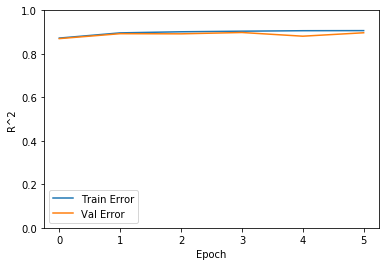

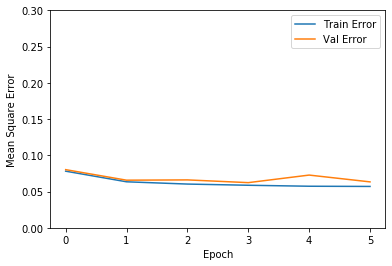

In [12]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('R^2')
  plt.plot(hist['epoch'], hist['r_squared'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_r_squared'],
           label = 'Val Error')
  plt.ylim([0,1])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,0.3])
  plt.legend()
  plt.show()


plot_history(history)

In [11]:
model.save('tf_model3.ckpt')